In [1]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from typing import List, Tuple

In [2]:
plt.rcParams['figure.figsize']  = (10, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['xtick.minor.width'] = 0
plt.rcParams['ytick.minor.size'] = 0
plt.rcParams['ytick.minor.width'] = 0

In [3]:
# See README in stress_test/results/ dir for more information on the expected format of the
# result files.
#
# read_results reads all files in a results directory, and returns two lists
# containing, respectively, the times and memory results, already averaged by
# the number of simulations performed.
def read_stress_results(
    result_path,
    min_logs: int = 1,
    max_logs: int = 1_000_000,
    num_simuls: int = 10,
) -> Tuple[List[float], List[float]]:
    results_dir = f"./stress_test/results/{result_path}"
    num_logs_ls = np.geomspace(min_logs, max_logs, int(np.log10(max_logs)) + 1).astype(int)

    times_agg = []
    memory_agg = []
    for num_logs in num_logs_ls:
        times = []
        memory = []
        for simul_num in range(num_simuls):
            test_result = open(f"{results_dir}/{num_logs}-{simul_num}").read()
            bynewline = test_result.split("\n")
            times.append(int(bynewline[0]))
            memory.append(int(bynewline[1]))
        times_agg.append(np.mean(times))
        memory_agg.append(np.mean(memory) / 1e6)
    
    return times_agg, memory_agg

In [4]:
def read_compare_results(
    result_path,
    min_logs: int = 1,
    max_logs: int = 1000,
    num_logs_step: int = 10,
    num_simuls: int = 10,
) -> Tuple[List[float], List[float]]:
    results_dir = f"./compare_to_zhe/results/{result_path}"
    num_logs_ls = np.geomspace(min_logs, max_logs, int(np.log10(max_logs)) + 1).astype(int)

    num_terminals_agg = []
    num_logs = min_logs
    while num_logs < max_logs:
        num_terminals = []
        for num_simul in range(num_simuls):
            test_result = open(f"{results_dir}/{num_logs}-{num_simul}").read()
            bynewline = [el for el in test_result.split("\n") if el != ""]
            num_terminals.append(int(bynewline[-2].split("=")[1]))
        num_terminals_agg.append(np.mean(num_terminals))
        num_logs += num_logs_step
    
    return num_terminals_agg

In [5]:
def plot_comparison(
    lists: List[List[float]],
    labels: List[str],
    step: int = 10,
    title: str = None,
    xscale: str = "log",
    yscale: str = "log",
    xlabel: str = "Number of logs",
    ylabel: str = "Time (milliseconds)",
    min_logs: int = 1,
    max_logs: int = 1_000_000,
    xticks=None,
    yticks=None,
    yticklabels=None,
    legend_loc=None,
    output=None,
) -> None:
    ax = plt.subplot()
    if title is not None:
        ax.set_title(title)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    color_sequence = ["black", "green", "darkgray", "cornflowerblue"]

    if xscale == "log":
        x = np.geomspace(min_logs, max_logs, int(np.log10(max_logs)) + 1).astype(int)
    else:
        x = np.insert(np.linspace(min_logs, max_logs, len(lists[0])), 0, 0)
        for l in lists:
            l.insert(0, 0)
    
    for i in range(len(lists)):
        ax.plot(x, lists[i], label=labels[i], color=color_sequence[i])

    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)

    ax.legend(loc=legend_loc)
    if output is not None:
        plt.savefig(output)
    else:
        plt.show()

## Stress tests

In [6]:
wout_loggen_times, wout_loggen_memory = read_stress_results("wout-lushu/log-generator")
wout_pglogs_times, wout_pglogs_memory = read_stress_results("wout-lushu/pglogs")
with_loggen_times, with_loggen_memory = read_stress_results("with-lushu/log-generator")
with_pglogs_times, with_pglogs_memory = read_stress_results("with-lushu/pglogs")

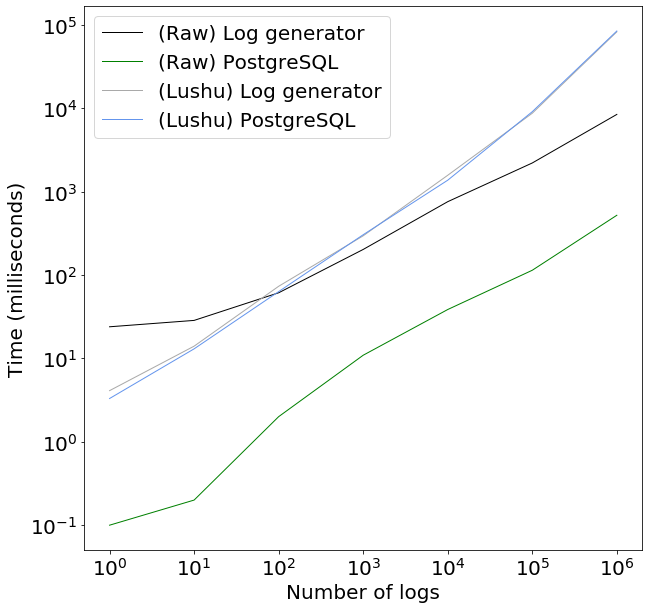

In [7]:
plot_comparison(
    [
        wout_loggen_times,
        wout_pglogs_times,
        with_loggen_times,
        with_pglogs_times,
    ],
    [
        "(Raw) Log generator",
        "(Raw) PostgreSQL",
        "(Lushu) Log generator",
        "(Lushu) PostgreSQL",
    ],
    output="stress_test/StressTestTime.png"
)

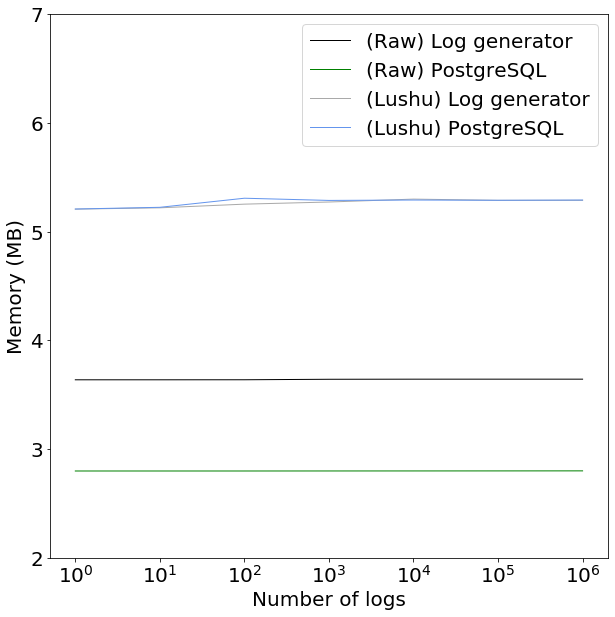

In [8]:
plot_comparison(
    [
        wout_loggen_memory,
        wout_pglogs_memory,
        with_loggen_memory,
        with_pglogs_memory,
    ],
    [
        "(Raw) Log generator",
        "(Raw) PostgreSQL",
        "(Lushu) Log generator",
        "(Lushu) PostgreSQL",
    ],
    ylabel="Memory (MB)",
    yscale="linear",
    yticks=[2, 3, 4, 5, 6, 7],
    output="stress_test/StressTestMemory.png"
)

## Comparison to Zhe

In [9]:
zhe_num_terminals = read_compare_results("zhe")
lushu_num_terminals = read_compare_results("lushu")

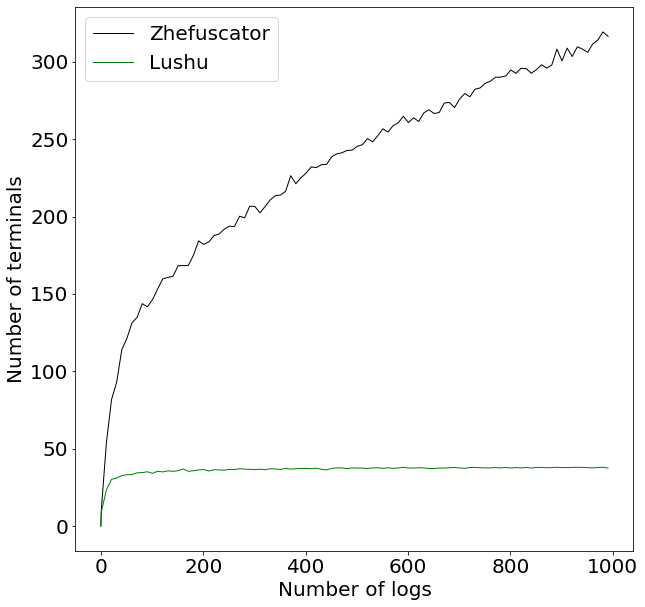

In [10]:
plot_comparison(
    [
        zhe_num_terminals,
        lushu_num_terminals,
    ],
    [
        "Zhefuscator",
        "Lushu",
    ],
    ylabel="Number of terminals",
    xscale="linear",
    yscale="linear",
    max_logs=991,
    output="compare_to_zhe/ComparisonWithZhe.png"
)